# Triplet Network Evaluation


In [1]:
# Move to the directory where the notebook is located
# and set directory to Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
%cd ..

c:\Users\duong\Downloads\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


C:\Users\duong\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Đảm bảo đang ở Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
# Cài đặt package
!pip install -e .

Obtaining file:///C:/Users/duong/Downloads/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for signature_verification (pyproject.toml): started
  Building editable for signature_verification (pyproject.toml): finished with status 'done'
  Created wheel for signature_verification: filename=signature_verification-0.1.0-0.editable-py3-none-any.whl size=3208 sha256=f1be275cbbb68fbeccf04242966dec06c3619c51145780d9e1f3a613e1f003f8
  Stored in direct


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import os
import sys
import time
import gc
import random
import psutil
import shutil
import kagglehub
import itertools

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

from utils.helpers import load_config, get_model_from_Kaggle, load_model
from losses.triplet_loss import DistanceNet
from models.Triplet_Siamese_Similarity_Network import tSSN
from dataloader.tSSN_testloader import SignatureTestDataset

In [4]:
print(os.getcwd())

c:\Users\duong\Downloads\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


## 1. Load Model  
- Load config, model, transform


In [5]:
# Load configuration
config = load_config('configs/config_tSSN.yaml')

# Device
device = torch.device('cuda' if torch.cuda.is_available() and config['device']=='cuda' else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Download models from Kaggle
model_path = get_model_from_Kaggle(config['model']['kaggle_handle'])

Model downloaded to C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1


In [9]:
# Define metrics and margins to test
metrics = ['cosine', 'euclidean', 'manhattan', 'learnable']
margins = [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

# Load all models
models = {}
for metric in metrics:
    for margin in margins:
        if metric == 'learnable':
            params = {'mode': metric, 'margin': 0}
            model = load_model(model_path, config['model']['backbone'], config['model']['feature_dim'], params)
            models[f"{metric}_0"] = (model, metric)
            break
        else:
            params = {'mode': metric, 'margin': margin}
            model = load_model(model_path, config['model']['backbone'], config['model']['feature_dim'], params)
            models[f"{metric}_{margin}"] = (model, metric)
    
    
print('All models loaded successfully.')

c:\Users\duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.2\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.4\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.6000000000000001\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_0.8\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_cosine_1.0\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_euclidean_0.2\tSSN.pth
Loaded model from C:\Users\duong\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\1\tSSN_euclidean_0.4\tSSN.pth
Loaded

In [29]:
for _ in models:
    print(_)

cosine_0.2
cosine_0.4
cosine_0.6000000000000001
cosine_0.8
cosine_1.0
euclidean_0.2
euclidean_0.4
euclidean_0.6000000000000001
euclidean_0.8
euclidean_1.0
manhattan_0.2
manhattan_0.4
manhattan_0.6000000000000001
manhattan_0.8
manhattan_1.0
learnable_0


## 2. Dataset Processing

In [11]:
# Image transform
size = config['dataset']['input_size']
if isinstance(size, str):
    size = tuple(map(int, size.strip('()').split(',')))
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(),  # Đảm bảo ảnh 1 kênh xám
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 kênh -> 3 kênh
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
pathA = kagglehub.dataset_download("divyanshrai/handwritten-signatures")
print("Path to dataset files [divyanshrai]:", pathA) #dataset A

Path to dataset files [divyanshrai]: C:\Users\duong\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2


In [13]:
dataset = r'C:\Users\duong\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2\sample_Signature\sample_Signature'
sys.path.append(dataset)

In [15]:
def rename_files(dataset_path):
    # Tạo các thư mục genuines và forged nếu chưa có
    genuines_dir = os.path.join(dataset_path, 'genuines_rename')
    forged_dir = os.path.join(dataset_path, 'forged_rename')
    os.makedirs(genuines_dir, exist_ok=True)
    os.makedirs(forged_dir, exist_ok=True)

    # Duyệt qua tất cả các file trong dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.startswith('NFI-') and (file.endswith('.png') or file.endswith('.PNG')):
                # Trích xuất XXX, YY, ZZZ từ tên file
                parts = file.split('-')[1].split('.')[0]
                XXX = parts[:3]  # ID người thực hiện chữ ký
                YY = parts[3:5]  # Số thứ tự mẫu ảnh
                ZZZ = parts[5:]  # ID người sở hữu chữ ký

                # Xác định là genuine hay forged và đặt tên mới
                if XXX == ZZZ:
                    new_name = f'original_{ZZZ}_{YY}.png'
                    target_dir = genuines_dir
                else:
                    new_name = f'forgery_{ZZZ}_{YY}.png'
                    target_dir = forged_dir

                # Đường dẫn file cũ và mới
                old_path = os.path.join(root, file)
                new_path = os.path.join(target_dir, new_name)

                # Di chuyển và đổi tên file
                shutil.move(old_path, new_path)
                print(f'Đã đổi tên: {file} -> {new_name}')

dataset_path = dataset
rename_files(dataset_path)

In [16]:
genuines_dir = dataset + '/genuines_rename'
forgery_dir = dataset + '/forged_rename'

# Tạo dataset
dataset = SignatureTestDataset(genuines_dir, forgery_dir, transform=transform)
batch_size = 32  # Chọn kích thước batch phù hợp
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f'Test dataset loaded with {len(dataset)} pairs.')

Test dataset loaded with 449 pairs.


In [17]:
# Preprocess data: Organize signatures by writer ID
writers = defaultdict(lambda: {'genuines': [], 'forged': []})

# Parse genuine signatures
for fname in os.listdir(genuines_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'original':
            writer_id = parts[1]  # e.g., '001' from 'original_001_01.png'
            writers[writer_id]['genuines'].append(os.path.join(genuines_dir, fname))

# Parse forged signatures
for fname in os.listdir(forgery_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'forgery':
            # e.g., '001' from 'forgery_001_01.png'
            writer_id = parts[1]  
            writers[writer_id]['forged'].append(os.path.join(forgery_dir, fname))

print(f"Number of writers: {len(writers)}")
# Print sample
for writer_id, data in list(writers.items())[:32]:  
    print(f"Writer {writer_id}: {len(data['genuines'])} genuines, {len(data['forged'])} forged")

Number of writers: 30
Writer 001: 5 genuines, 5 forged
Writer 002: 5 genuines, 5 forged
Writer 003: 5 genuines, 5 forged
Writer 004: 5 genuines, 5 forged
Writer 005: 5 genuines, 5 forged
Writer 006: 5 genuines, 5 forged
Writer 007: 5 genuines, 5 forged
Writer 008: 5 genuines, 5 forged
Writer 009: 5 genuines, 5 forged
Writer 010: 5 genuines, 4 forged
Writer 011: 5 genuines, 5 forged
Writer 012: 5 genuines, 5 forged
Writer 013: 5 genuines, 5 forged
Writer 014: 5 genuines, 5 forged
Writer 015: 5 genuines, 5 forged
Writer 016: 5 genuines, 5 forged
Writer 017: 5 genuines, 5 forged
Writer 018: 5 genuines, 5 forged
Writer 019: 5 genuines, 5 forged
Writer 020: 5 genuines, 5 forged
Writer 021: 5 genuines, 5 forged
Writer 022: 5 genuines, 5 forged
Writer 023: 5 genuines, 5 forged
Writer 024: 5 genuines, 5 forged
Writer 025: 5 genuines, 5 forged
Writer 026: 5 genuines, 5 forged
Writer 027: 5 genuines, 5 forged
Writer 028: 5 genuines, 5 forged
Writer 029: 5 genuines, 5 forged
Writer 030: 5 genuine

In [36]:
# Hàm tính khoảng cách dựa trên metric được chọn
def calculate_distance(anchor_feat, test_feat, metric='euclidean'):
    distance_net = DistanceNet(input_dim=512).to(device)
    if metric == 'euclidean':
        return F.pairwise_distance(anchor_feat, test_feat)
    elif metric == 'cosine':
        anchor_feat = F.normalize(anchor_feat, p=2, dim=1)
        test_feat = F.normalize(test_feat, p=2, dim=1)
        return 1 - torch.sum(anchor_feat * test_feat, dim=1)
    elif metric == 'manhattan':
        return torch.sum(torch.abs(anchor_feat - test_feat), dim=1)
    elif metric == 'learnable':
        return distance_net(anchor_feat, test_feat)
    else:
        raise ValueError(f"Metric không được hỗ trợ: {metric}")

In [37]:
# Hàm đánh giá mô hình
def evaluate_model(model, metric, dataloader, device):
    model.eval()
    distances = []
    labels = []

    with torch.no_grad():
        for (img1, img2), label in tqdm(dataloader, desc=f'Evaluating with {metric}'):
            img1, img2 = img1.to(device), img2.to(device)
            emb1 = model.feature_extractor(img1)
            emb2 = model.feature_extractor(img2)
            dist = calculate_distance(emb1, emb2, metric)
            distances.extend(dist.cpu().numpy())
            labels.extend(label.numpy())

    distances = np.array(distances)
    labels = np.array(labels)

    # Tìm ngưỡng tối ưu bằng ROC curve
    fpr, tpr, thresholds = roc_curve(labels, -distances)  # -distances vì nhỏ hơn nghĩa là giống hơn
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = -thresholds[optimal_idx]  # Chuyển lại dấu

    # Tính các chỉ số hiệu suất
    predictions = (distances <= optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    roc_auc = auc(fpr, tpr)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'threshold': optimal_threshold
    }

In [ ]:
# Đánh giá tất cả các mô hình
results = {}

for key, (model, metric) in models.items():
    model.to(device)
    print(f'\nEvaluating model: {key}')
    results[key] = evaluate_model(model, metric, dataloader, device)


Evaluating model: learnable_0


Evaluating with learnable: 100%|██████████| 15/15 [00:48<00:00,  3.23s/it]


In [39]:
# Tổng hợp kết quả thành DataFrame
pd.set_option('display.width', 1000)
results_df = pd.DataFrame(results).T
results_df.index.name = 'Metric_Margin'
print('\nResults Table:')
print(results_df)


Results Table:
               accuracy  precision  recall        f1   roc_auc  threshold
Metric_Margin                                                            
learnable_0    0.432071   0.347826     0.8  0.484848  0.494894   0.718432


In [40]:
metric_columns = ['accuracy']

best_by_metric = {}
for metric in metric_columns:
    best_model_idx = results_df[metric].idxmax()  # Lấy index của mô hình có giá trị cao nhất
    best_by_metric[metric] = results_df.loc[best_model_idx]

print("Best models by each metric:")
for metric, best_model in best_by_metric.items():
    print(f"Best for {metric}: {best_model.name} with {metric} = {best_model[metric]:.4f}")

Best models by each metric:
Best for accuracy: learnable_0 with accuracy = 0.4321


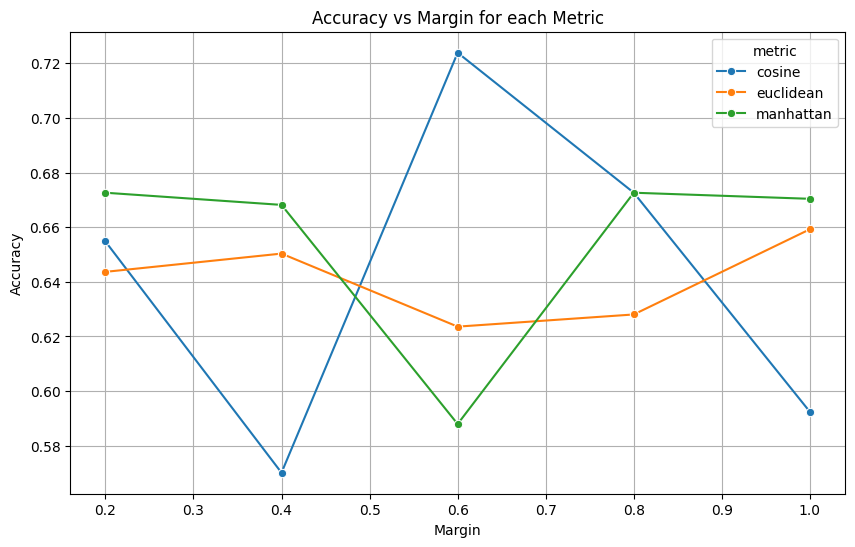

In [23]:
results_df['metric'] = results_df.index.str.split('_').str[0]
results_df['margin'] = results_df.index.str.split('_').str[1].astype(float)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='margin', y='accuracy', hue='metric', marker='o')
plt.title('Accuracy vs Margin for each Metric')
plt.xlabel('Margin')
plt.ylabel('Accuracy')
plt.grid(True)  # Thêm lưới
plt.show()

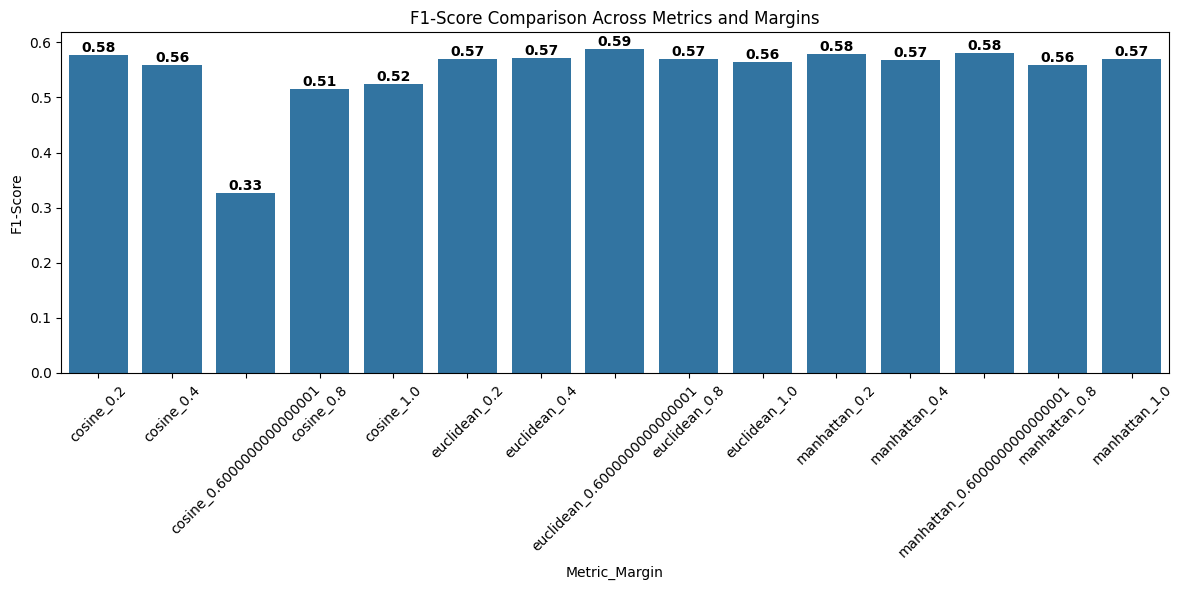

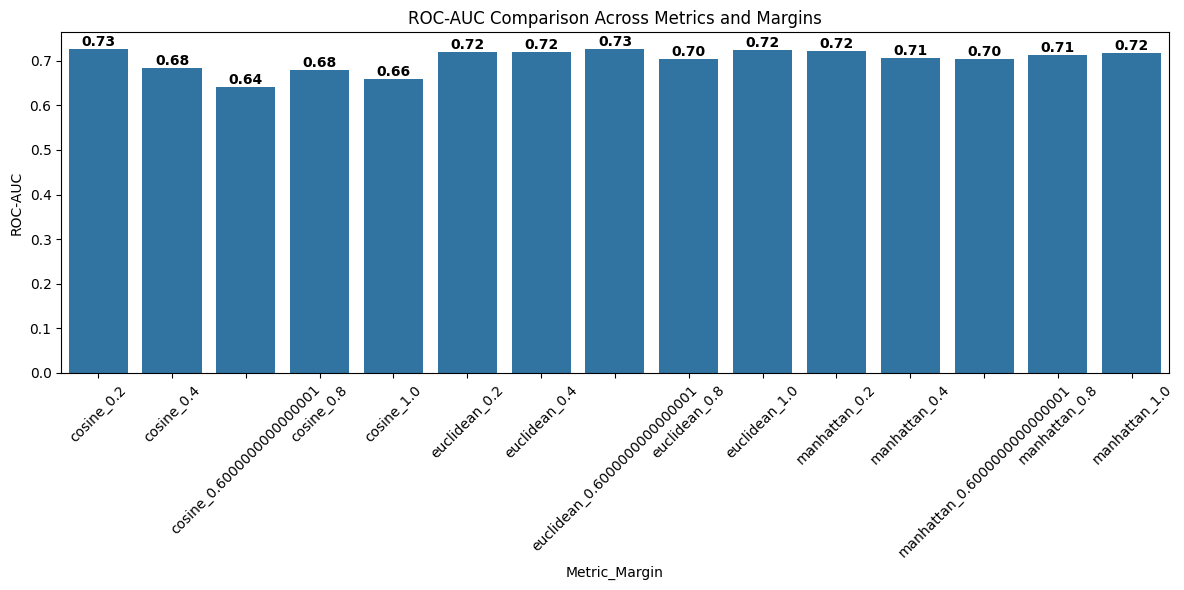

In [ ]:
# Vẽ biểu đồ so sánh F1-score
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=results_df.index, y='f1', data=results_df)

# Thêm nhãn giá trị lên từng cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.xticks(rotation=45)
plt.title('F1-Score Comparison Across Metrics and Margins')
plt.xlabel('Metric_Margin')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.show()

# Vẽ biểu đồ so sánh ROC-AUC
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=results_df.index, y='roc_auc', data=results_df)

# Thêm nhãn giá trị lên từng cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.xticks(rotation=45)
plt.title('ROC-AUC Comparison Across Metrics and Margins')
plt.xlabel('Metric_Margin')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.grid(True)  # Thêm lưới
plt.show()